In [92]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from astropy.io import fits
from astropy.table import Table

In [5]:
filename = '/mnt/data-storage/apogee/dr17/allStar-dr17-synspec_rev1.fits'

with fits.open(filename) as hdul:
    table = Table.read(hdul[1])

In [13]:
names = [name for name in table.colnames if len(table[name].shape) <= 1]
df = table[names].to_pandas()
df["GAIAEDR3_PARALLAX_OVER_ERROR"] = df['GAIAEDR3_PARALLAX'] / df['GAIAEDR3_PARALLAX_ERROR']
df.head()

,FILE,APOGEE_ID,TARGET_ID,APSTAR_ID,ASPCAP_ID,TELESCOPE,LOCATION_ID,FIELD,ALT_ID,RA,...,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG,YB_FE,YB_FE_SPEC,YB_FE_ERR,YB_FE_FLAG
0,apStar-dr17-VESTA.fits,VESTA,apo1m.calibration.VESTA,apogee.apo1m.stars.calibration.VESTA,apogee.apo1m.synspec_fix.calibration.VESTA,apo1m,1,calibration,,NaN,...,0.059403,2,NaN,NaN,NaN,64,NaN,NaN,1.0,2
1,apStar-dr17-2M00000002+7417074.fits,2M00000002+7417074,apo25m.120+12.2M00000002+7417074,apogee.apo25m.stars.120+12.2M00000002+7417074,apogee.apo25m.synspec_fix.120+12.2M00000002+74...,apo25m,5046,120+12,none,0.000103,...,0.001221,2,NaN,NaN,NaN,64,NaN,NaN,1.0,2
2,apStar-dr17-2M00000019-1924498.fits,2M00000019-1924498,apo25m.060-75.2M00000019-1924498,apogee.apo25m.stars.060-75.2M00000019-1924498,apogee.apo25m.synspec_fix.060-75.2M00000019-19...,apo25m,5071,060-75,none,0.000832,...,0.102594,2,NaN,NaN,NaN,64,NaN,NaN,1.0,2
3,apStar-dr17-2M00000032+5737103.fits,2M00000032+5737103,apo25m.116-04.2M00000032+5737103,apogee.apo25m.stars.116-04.2M00000032+5737103,apogee.apo25m.synspec_fix.116-04.2M00000032+57...,apo25m,4424,116-04,none,0.001335,...,0.123839,2,NaN,NaN,NaN,64,NaN,NaN,1.0,2
4,apStar-dr17-2M00000032+5737103.fits,2M00000032+5737103,apo25m.N7789.2M00000032+5737103,apogee.apo25m.stars.N7789.2M00000032+5737103,apogee.apo25m.synspec_fix.N7789.2M00000032+573...,apo25m,4264,N7789,none,0.001335,...,0.107103,2,NaN,NaN,NaN,64,NaN,NaN,1.0,2


In [278]:
def any_bits_in_bitmask(bitmask, bits=None):
    if bits is None:
        bits = range(0, np.iinfo(bitmask).bits)
    return any((bitmask & 1 << bit) > 0 for bit in bits)

In [366]:
# M_H_WARN, ALPHA_M_WARN, STAR_WARN, M_H_BAD, ALPHA_M_BAD, STAR_BAD, or MULTIPLE_SUSPECT
# bits = [3, 4, 7, 19, 20, 23, 41]
# M_H_BAD, ALPHA_M_BAD, STAR_BAD, or MULTIPLE_SUSPECT
bits = [19, 20, 23, 41]
flag = df['ASPCAPFLAG'].apply(any_bits_in_bitmask, args=(bits,))
print(flag.sum(), 'stars flagged')

48264 stars flagged


In [389]:
mask = (
    (df['GAIAEDR3_PARALLAX'] > 1) & (df['GAIAEDR3_PARALLAX_OVER_ERROR'] > 5)
    & (df["M_H"] > -0.9)
    & (df['ALPHA_M'] > -0.3) & (df['ALPHA_M'] < 0.3)
    & (df['LOGG'] > 2.5)
    & ~(
        ((df['TEFF'] - df['TEFF_ERR']) < 4500.)
#         & ((df['LOGG'] + df['LOGG_ERR']) > 4.2)
    )
    & ~flag
)
print(mask.sum(), 'stars selected')

215626 stars selected


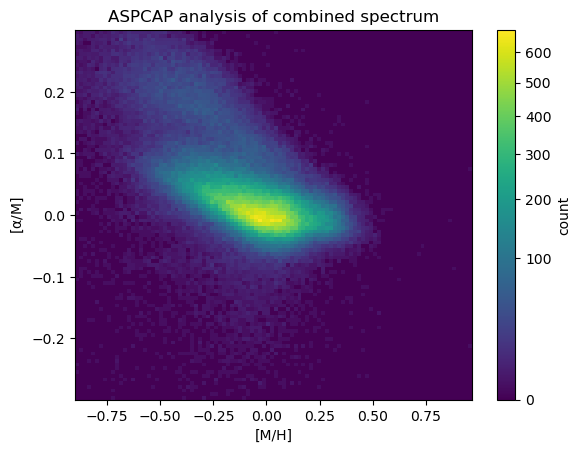

In [390]:
fig, ax = plt.subplots()

*_, im = ax.hist2d(df.loc[mask, 'M_H'], df.loc[mask, 'ALPHA_M'], bins=100, norm=mcolors.PowerNorm(1/2))

ax.set_xlabel('[M/H]')
ax.set_ylabel(r'$[\mathrm{\alpha/M}]$')
ax.set_title('ASPCAP analysis of combined spectrum')
fig.colorbar(im, label='count');

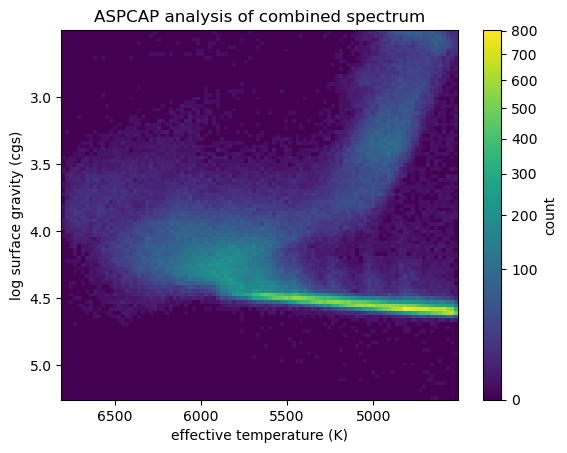

In [391]:
fig, ax = plt.subplots()

*_, im = ax.hist2d(df.loc[mask, 'TEFF'], df.loc[mask, 'LOGG'], bins=100, norm=mcolors.PowerNorm(1/2))
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_xlabel('effective temperature (K)')
ax.set_ylabel('log surface gravity (cgs)')
ax.set_title('ASPCAP analysis of combined spectrum')
fig.colorbar(im, label="count");

In [392]:
num_samples = 5000
idx = df.loc[mask].sample(num_samples).index

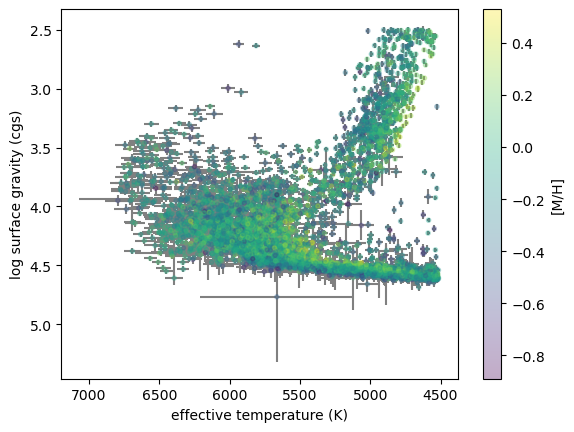

In [393]:
fig, ax = plt.subplots()

ax.errorbar(
    df.loc[mask, 'TEFF'].loc[idx], 
    df.loc[mask, 'LOGG'].loc[idx], 
    xerr=df.loc[mask, 'TEFF_ERR'].loc[idx],
    yerr=df.loc[mask, 'LOGG_ERR'].loc[idx],
    ls='none',
    zorder=0,
    c='gray',
)
s = ax.scatter(df.loc[mask, 'TEFF'].loc[idx], df.loc[mask, 'LOGG'].loc[idx], 
               c=df.loc[mask, 'M_H'].loc[idx], marker='.', alpha=0.33)
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_xlabel('effective temperature (K)')
ax.set_ylabel('log surface gravity (cgs)')
fig.colorbar(s, label='[M/H]');